# TextBoxes++ Tutorial
___
> 본 스크립트는 https://github.com/mvoelk/ssd_detectors 의 코드를 기반으로 제작되었습니다.
## - A Single-Shot Oriented Scene Text Detector

이 스크립트는 "TextBoxes++ : A Single-Shot Oriented Scene Text Detector" 논문을 기반으로 하는 객체 인식의 end-to-end 튜토리얼 과정을 담고 있습니다. TextBoxes++에서는 기존 객체 인식에서 다양한 가로세로비를 가진 단어를 탐지하는데에 겪던 어려움을 효율적으로 해결하기 위해 구체적으로 디자인된 text-box layer를 사용합니다. TextBoxes++에서는 기존 객체인식에서 사용해왔던 수평적인 직사각형 형태의 바운딩 박스(bounding box)뿐만 아니라 일반적인 사각형 형태의 바운딩 박스와 회전된 직사각형 형태의 바운딩 박스를 생성할 수 있습니다.

해당 튜토리얼을 순서대로 끝까지 진행하면 아래와 같은 결과를 얻을 수 있습니다.

<img src="https://i.imgur.com/YgA4EJe.png" width="800">

위 이미지는 SynthText 데이터셋을 사용하여 훈련시켰을 때의 결과를 보여줍니다. 파란색 박스는 바운딩 박스를 포함하는 최소한의 수평적인 직사각형을, 빨간색 박스는 회전된 직사각형 형태의 바운딩박스를, 초록색 박스는 일반적인 사각형 형태의 바운딩 박스를 의미합니다. 

In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
assert int(tf.__version__.split('.')[0]) ==1, "Textboxes++은 tensorflow 2.0대 버전을 지원하지 않습니다."

import matplotlib.pyplot as plt

## 1. Setup input pipeline

모든 데이터셋은 `data`폴더 내에 각각 존재하고 있습니다. 우리가 사용할 Syntext 데이터셋을 불러오도록 하겠습니다. Syntext 데이터셋은 7,266,866개의 단어들로 이루어진 858,750장의 합성 이미지 파일이 200개의 폴더에 나누어져 담겨있으며 Ground-truth annotation은 `gt.mat`파일에 담겨있습니다. <br><br>

### Check dataset

데이터셋은 [Synth-text Downloads](https://www.robots.ox.ac.uk/~vgg/data/scenetext/) 에서 다운받으실 수 있습니다. 다운 받은 데이터는 `data/SynthText/` 디렉토리 내 저장해주시길 바랍니다.<br>

저장하면, 아래와 같은 디렉토리 구성을 가지게 됩니다.

````
data/SynthText/
        |- 1/
            |- ant+hill_100_0.jpg
            |- ant+hill_100_1.jpg
            |- ...
        |- 2/
        |- 3/
        |- ....
        |- gt.mat
````

In [2]:
from data_utils.synthtext import GTUtility
gt_util = GTUtility('data/SynthText/', polygon=True)

print(gt_util)

loding ground truth data...
processing samples...
Background              0
Text              7266338

images             858749
objects           7266338
per image            8.46
no annotation           0



아래의 코드를 통해, 현재 데이터를 시각화할 수 있습니다.

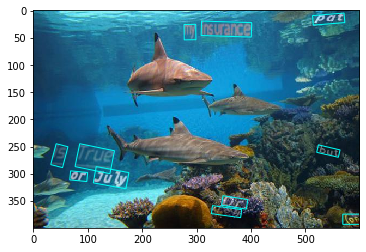

In [3]:
idx, img, gt = gt_util.sample()

plt.imshow(img)
gt_util.plot_gt(gt, show_labels=False)
plt.show()

### Set dataset

Train / Validation은 아래와 같이 `gt_util.split` 메소드를 이용하여 쉽게 나눌 수 있습니다.

In [4]:
gt_util_train, gt_util_val = gt_util.split(0.9)

## 2. Build Model

TextBoxes++의 모델은 기본적으로 VGG-16의 13개의 layer와 그 뒤로 10개의 convolutional layer가 추가로 붙어 있으며, 중간 중간 layer와 연결된 6개의 Text-box layers로 구성되어 있습니다. Text-box layer의 각 layer는 글자의 존재유무, 수평적인 직사각형 바운딩 박스, 회전된 직사각형 형태의 바운딩 박스, 일반적인 사각형 형태의 바운딩 박스에 대한 정보를 predict합니다. Text-box layer의 뒤에는 non-maximum suppression이 수행됩니다.

<img src="https://i.imgur.com/V1rfeNo.png" width="800" heigth="600">

In [5]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.models import Model

In [6]:
from utils.model import Normalize

### Build text-box layer

* 먼저 Text-box layer를 구성해보도록 하겠습니다.

In [7]:
def tbpp384_body(x):
    
    source_layers = []
    
    # Block 1
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_1', activation='relu')(x)
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool1')(x)
    # Block 2
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_1', activation='relu')(x)
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool2')(x)
    # Block 3
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_2', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_3', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool3')(x)
    # Block 4
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_3', activation='relu')(x)
    source_layers.append(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool4')(x)
    # Block 5
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_3', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=1, padding='same', name='pool5')(x)
    # FC6
    x = Conv2D(1024, 3, strides=1, dilation_rate=(6, 6), padding='same', name='fc6', activation='relu')(x)
    # FC7
    x = Conv2D(1024, 1, strides=1, padding='same', name='fc7', activation='relu')(x)
    source_layers.append(x)
    # Block 6
    x = Conv2D(256, 1, strides=1, padding='same', name='conv6_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(512, 3, strides=2, padding='valid', name='conv6_2', activation='relu')(x)
    source_layers.append(x)
    # Block 7
    x = Conv2D(128, 1, strides=1, padding='same', name='conv7_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv7_2', activation='relu')(x)
    source_layers.append(x)
    # Block 8
    x = Conv2D(128, 1, strides=1, padding='same', name='conv8_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='valid', name='conv8_2', activation='relu')(x)
    source_layers.append(x)
    # Block 9
    x = Conv2D(128, 1, strides=1, padding='same', name='conv9_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='valid', name='conv9_2', activation='relu')(x)
    source_layers.append(x)
    
    return source_layers

### Bulid multibox head

* Text-box layer의 각 layer는 글자의 존재유무(`mbox_conf`), 글자를 포괄하는 최소 직사각형 바운딩 박스(`mbox_loc`), 일반적인 사각형 형태의 바운딩 박스에 대한 정보(`mbox_quad`), 회전된 직사각형 형태의 바운딩 박스(`mbox_rbox`)를 predict합니다. 이를 메소드로 구현해보도록 하겠습니다.

In [8]:
def multibox_head(source_layers, num_priors, normalizations=None, softmax=True):
    
    num_classes = 2
    class_activation = 'softmax' if softmax else 'sigmoid'

    mbox_conf = []
    mbox_loc = []
    mbox_quad = []
    mbox_rbox = []
    for i in range(len(source_layers)):
        x = source_layers[i]
        name = x.name.split('/')[0]
        
        # normalize
        if normalizations is not None and normalizations[i] > 0:
            name = name + '_norm'
            x = Normalize(normalizations[i], name=name)(x)
            
        # confidence
        name1 = name + '_mbox_conf'
        x1 = Conv2D(num_priors[i] * num_classes, (3, 5), padding='same', name=name1)(x)
        x1 = Flatten(name=name1+'_flat')(x1)
        mbox_conf.append(x1)

        # location, Delta(x,y,w,h)
        name2 = name + '_mbox_loc'
        x2 = Conv2D(num_priors[i] * 4, (3, 5), padding='same', name=name2)(x)
        x2 = Flatten(name=name2+'_flat')(x2)
        mbox_loc.append(x2)
        
        # quadrilateral, Delta(x1,y1,x2,y2,x3,y3,x4,y4)
        name3 = name + '_mbox_quad'
        x3 = Conv2D(num_priors[i] * 8, (3, 5), padding='same', name=name3)(x)
        x3 = Flatten(name=name3+'_flat')(x3)
        mbox_quad.append(x3)

        # rotated rectangle, Delta(x1,y1,x2,y2,h)
        name4 = name + '_mbox_rbox'
        x4 = Conv2D(num_priors[i] * 5, (3, 5), padding='same', name=name4)(x)
        x4 = Flatten(name=name4+'_flat')(x4)
        mbox_rbox.append(x4)
        
    mbox_conf = concatenate(mbox_conf, axis=1, name='mbox_conf')
    mbox_conf = Reshape((-1, num_classes), name='mbox_conf_logits')(mbox_conf)
    mbox_conf = Activation(class_activation, name='mbox_conf_final')(mbox_conf)
    
    mbox_loc = concatenate(mbox_loc, axis=1, name='mbox_loc')
    mbox_loc = Reshape((-1, 4), name='mbox_loc_final')(mbox_loc)
    
    mbox_quad = concatenate(mbox_quad, axis=1, name='mbox_quad')
    mbox_quad = Reshape((-1, 8), name='mbox_quad_final')(mbox_quad)
    
    mbox_rbox = concatenate(mbox_rbox, axis=1, name='mbox_rbox')
    mbox_rbox = Reshape((-1, 5), name='mbox_rbox_final')(mbox_rbox)

    predictions = concatenate([mbox_loc, mbox_quad, mbox_rbox, mbox_conf],
                              axis=2, name='predictions')
    
    return predictions

### Build TextBoxes++ 384 model

* 위에서 구현한 메소드들을 토대로 TBPP384 model을 구성해보도록 하겠습니다.

In [9]:
def TBPP384(input_shape=(384, 384, 3), softmax=True):
    """TextBoxes++384 architecture.

    # Arguments
        input_shape: Shape of the input image.
    
    # References
        - [TextBoxes++: A Single-Shot Oriented Scene Text Detector](https://arxiv.org/abs/1801.02765)
    """
    
    # TBPP body
    x = input_tensor = Input(shape=input_shape)
    source_layers = tbpp384_body(x)
    
    num_maps = len(source_layers)
    
    # Add multibox head for classification and regression
    num_priors = [14] * num_maps
    normalizations = [1] * num_maps
    output_tensor = multibox_head(source_layers, num_priors, normalizations, softmax)
    model = Model(input_tensor, output_tensor)
    
    # parameters for prior boxes
    model.image_size = input_shape[:2]
    model.source_layers = source_layers
    
    # Hyper-Parameter에 대한 설명 + Hyper-Parameter를 변경하는 팁
    model.aspect_ratios = [[1,2,3,5,1/2,1/3,1/5] * 2] * num_maps
    model.shifts = [[(0.0, -0.25)] * 7 + [(0.0, 0.25)] * 7] * num_maps
    model.special_ssd_boxes = False
    model.scale = 0.5
    
    return model

In [10]:
model = TBPP384(softmax=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


위의 모델은 미리 구현해 놓은 모듈을 사용해 아래와 같이 불러올 수 있습니다.

In [11]:
K.clear_session()
from utils.model import TBPP384
model = TBPP384(softmax=False)

## 3. Setting prior boxes

객체 인식을 위해 Text-box layer의 각 layer마다 가상의 box인 prior box를 설정해줍니다. 이 prior box는 multibox_head가 물체를 잡을 때 기준이 되는 box로, prior box에 물체가 일정 수치 이상 겹쳤을 때에만 동작하도록 구성됩니다. 

* Text-box layer의 각 feature map 별 prior box의 중심좌표를 시각화해보겠습니다.

In [12]:
from utils.prior import PriorMap

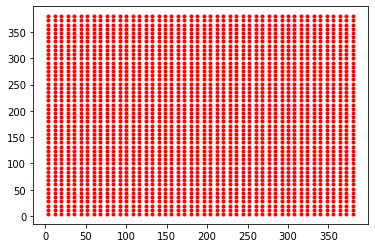

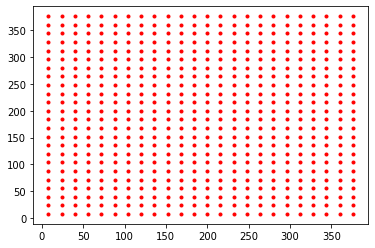

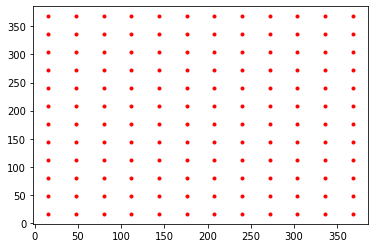

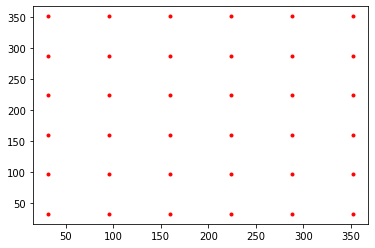

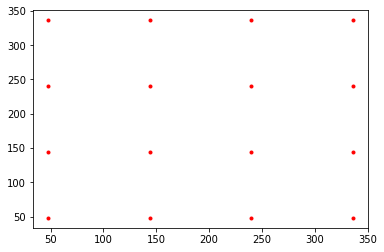

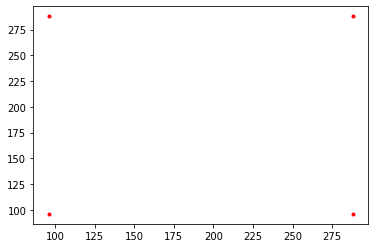

In [13]:
source_layers_names = [l.name.split('/')[0] for l in model.source_layers]
for i in range(len(source_layers_names)):
    num_maps = len(source_layers_names)
    min_dim = np.min(model.image_size)
    min_ratio = 10 # 15
    max_ratio = 100 # 90
    s = np.linspace(min_ratio, max_ratio, num_maps+1) * min_dim / 100.
    minmax_sizes = [(round(s[i]), round(s[i+1])) for i in range(len(s)-1)]

    
    layer = model.source_layers[i]
    map_h, map_w = map_size = layer.get_shape().as_list()[1:3]
    m = PriorMap(source_layer_name=source_layers_names[i],
                 image_size=model.image_size,
                 map_size=map_size,
                 minmax_size=minmax_sizes[i],
                 variances=[0.1, 0.1, 0.2, 0.2],
                 aspect_ratios=model.aspect_ratios[i],
                 shift=model.shifts[i],
                 step=None,
                 special_ssd_box=False,
                 clip=False)
    
    m.compute_priors()
    m.plot_locations()
    plt.show()

* 각 중심좌표당 14개의 prior box의 모습은 아래와 같습니다.

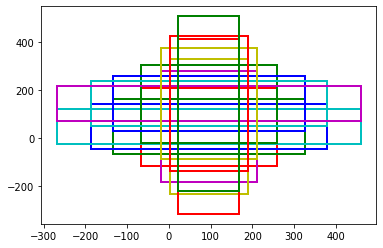

In [15]:
m.plot_boxes([0])

### Setting prior utils

Prior box와 물체가 겹쳤는지를 판단하는 지표로 일반적으로 IOU(intersection over union)를 사용합니다. <br>
Textboxes++의 경우 수평적인 직사각형 형태의 바운딩 박스를 다루는 것이 아니므로, 이를 계산하기 매우 까다롭습니다. <br>
계산문제를 해결하기 위해, 우리는 일반적인 사각형 혹은 회전된 직사각형 형태의 바운딩 박스를 모두 포함하는 최소한의 수평적인 직사각형 형태의 바운딩 박스를 기준으로 iou를 계산합니다. <br> 
IOU계산을 위해 우리는 기존 형태의 바운딩 박스에서 수평적인 직사각형 행태의 바운딩 박스로 변환하는 encoding과정과 다시 기존 형태의 바운딩 박스로 변환해주는 decoding 과정이 필요합니다.

IOU계산, non-maximum suppression을 진행하는 과정은 미리 구현해 놓은 모듈을 사용해 불러오겠습니다.

In [12]:
from utils.prior import PriorUtil

In [16]:
prior_util = PriorUtil(model)

* Training 단계로 넘어가기 전에, 샘플 이미지에 prior box들을 시각화 해보겠습니다.

In [31]:
import cv2

In [33]:
sample_img = cv2.resize(img, (384,384))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


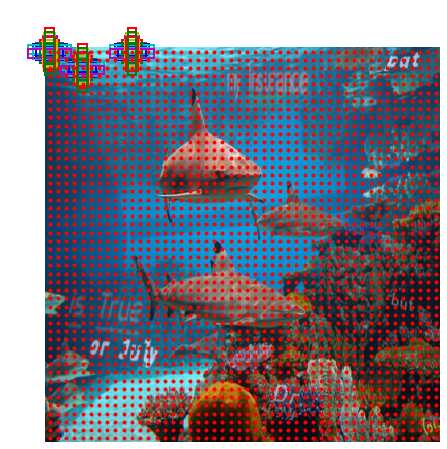

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


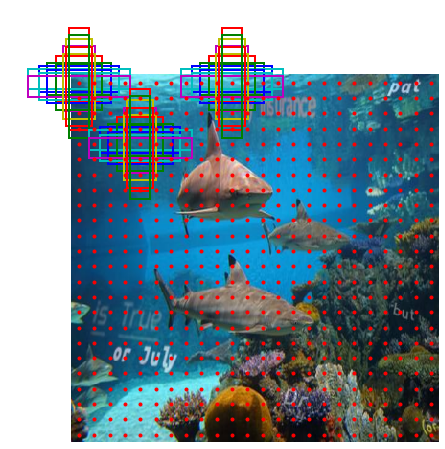

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


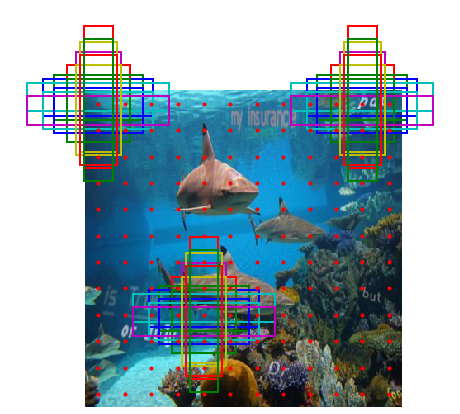

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


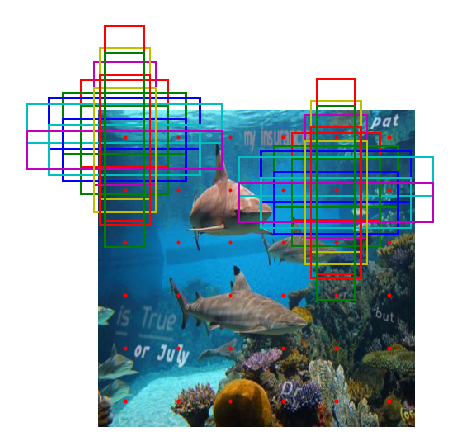

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


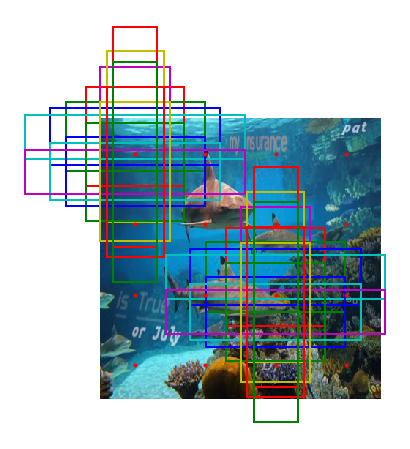

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


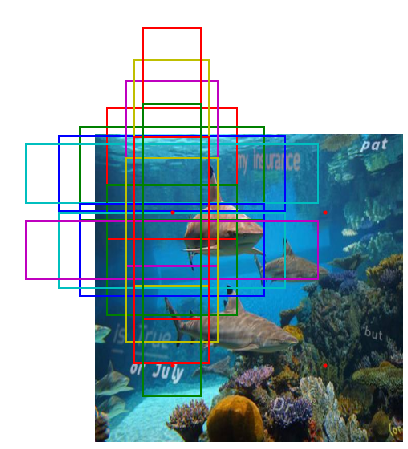

In [34]:
for m in prior_util.prior_maps:
    plt.figure(figsize=[8]*2)
    plt.imshow(sample_img)
    m.plot_locations()
    m.plot_boxes([0, 10, 100])
    plt.axis('off')
    plt.show()

## 4. Training

In [ ]:
from utils.model import TBPP384
from utils.prior import PriorUtil
from utils.data import InputGenerator
from utils.training import TBPPFocalLoss
from utils.training import Logger

### Input Generater

* Data augmentation을 진행하는 Input Generator입니다.

In [ ]:
batch_size = 32
gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size)
gen_val = InputGenerator(gt_util_val, prior_util, batch_size*4, model.image_size)

`next`를 통해 다음 이미지를 확인할 수 있습니다.

In [ ]:
generator = gen_train.generate()

In [ ]:
next(generator)

### Loss & metrics

* **Loss**

우리가 학습해야 하는 것은 위치를 추론하는 Regressor와 사물인지 아닌지를 구분하는 Classifer입니다. TextBoxes++ 논문에서, Regressor의 경우에는 SmoothL1이라 불리는 Loss를 사용하고, Classifier은 분류모델에서 주로 사용하는 Cross-Entropy Loss를 사용합니다. <br><br>
$$
smooth_{L1}(x) = \begin{cases}
0.5x^2, \mbox{  if  } |x| <1\\
|x| - 0.5 \mbox{   otherwise,}
\end{cases}
$$

본 스크립트에서는 Cross=Entropy Loss대신 Focal Loss를 사용하도록 하겠습니다. Focal Loss는 기존의 Hard Negative Sampling 방법 대신 이용할 수 있는 방법론으로, Loss 식을 바꾸는 것 만으로도 성능을 개선할 수 있습니다. <br><br>
Focal Loss 는 잘 분류된 예제들에 대해서는 작은 가중치를 부여하는 반면 분류하기 어려운 일부 예제들에는 큰 가중치를 부여해서 학습을 어려운 예제에 집중시킴으로써 객체 인식의 고질적인 문제점인 극단적인 class imbalance 문제를 해결합니다.

$$
p_t = \begin{cases}
p && \mbox{if y = 1} \\
1-p && \mbox{otherwise,}
\end{cases} \\
FL(p_t) = - (1-p_t)^\gamma log(p_t).
$$

<img src="https://i.imgur.com/lmMkV3X.png" width="400" heigth="300">

$\gamma$ > 0 으로 셋팅하면 상대적으로 잘 분류된 예제들(well-classified examples: $p_t$ > 0.5)의 로스를 줄일 수 있고 이를 통해 잘못 분류된 예제들에게 더욱 집중할 수 있습니다.

* **Metrics**

Metric으로는 흔히 사용하는 F1 score를 사용하도록 하겠습니다.

$$
recall = \frac{TP}{TP+FN},~precision = \frac{TP}{TP+FP} \\
F = 2* \frac{recall * precision}{recall + precision}
$$

해당 class는 미리 구현해놓은 모듈을 통해 사용할 수 있습니다.

In [ ]:
from utils.training import TBPPFocalLoss
loss = TBPPFocalLoss(lambda_conf=10000.0, lambda_offsets=1.0)

### Optimizer

* TextBoxes++ 논문에서는 Optimizer로 Adam optimizer를 사용했지만, 본 스크립트에서는 보다 더 빠른 training을 위해 SGD를 사용하겠습니다.

In [ ]:
optim = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0, nesterov=True)

### Checkpointing

* 각 epoch마다 checkpoints들을 저장하기 위해 checkpoint를 저장할 경로를 지정해줍니다.

In [ ]:
import time
experiment = 'tbpp384fl_synthtext'
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

### Training

* end-to-end training 과정입니다.

In [ ]:
from multiprocessing import cpu_count
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
epochs = 10
batch_size = 32

gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size)
gen_val = InputGenerator(gt_util_val, prior_util, batch_size*4, model.image_size)

checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

optim = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0, nesterov=True)
# optim = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0)

# weight decay
regularizer = tf.keras.regularizers.l2(5e-4) # None if disabled
#regularizer = None
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

loss = TBPPFocalLoss(lambda_conf=10000.0, lambda_offsets=1.0)

model.compile(optimizer=optim, loss=loss.compute, metrics=loss.metrics)

callbacks = [
    ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', 
                    verbose=1, save_weights_only=True),
    Logger(checkdir)
]

print(checkdir.split('/')[-1])
history = model.fit_generator(
        gen_train.generate(),
        epochs=epochs, 
        steps_per_epoch=int(gen_train.num_batches/4), 
        callbacks=callbacks,
        validation_data=gen_val.generate(), 
        validation_steps=int(gen_val.num_batches/4),
        workers=cpu_count(), 
        use_multiprocessing=True)

## 5. Evaluation

In [ ]:
from tqdm import tqdm

from utils.model import TBPP384
from utils.metric import fscore
from utils.metric import evaluate_polygonal_results
from utils.bboxes import rbox3_to_polygon, polygon_to_rbox3
from utils.vis import plot_box

### Load Model

* 평가를 위해 위에서 훈련한 모델을 불러오겠습니다. `weights_path`에는 훈련과정에서 checkpoint를 이용해 저장한 모델의 경로를 설정해 주세요.

```python
# 예시
weights_path = './checkpoints/201911120606_tbpp384fl_synthtext/weights.010.h5'
```

In [ ]:
# TextBoxes++
K.clear_session()
model = TBPP384(softmax=False)
weights_path = ''
plot_name = 'tbpp384fl_synthtext'

In [ ]:
model.load_weights(weights_path)
checkdir = os.path.dirname(weights_path)
prior_util = PriorUtil(model)

### Prediction

* 훈련 결과를 시각화 해보겠습니다.

In [ ]:
_, inputs, images, data = gt_util_val.sample_random_batch(1024)

preds = model.predict(inputs, batch_size=1, verbose=1)

In [ ]:
confidence_threshold = 0.4

In [ ]:
for i in range(16):
    res = prior_util.decode(preds[i], confidence_threshold, fast_nms=False)
    bbox = res[:,0:4]
    quad = res[:,4:12]
    rbox = res[:,12:17]
    #print(bbox)
    
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    ax = plt.gca()
    for j in range(len(bbox)):
        #ax.add_patch(plt.Polygon(p, fill=False, edgecolor='r', linewidth=1))
        plot_box(bbox[j]*384, box_format='xyxy', color='b')
        plot_box(np.reshape(quad[j],(-1,2))*384, box_format='polygon', color='r')
        plot_box(rbox3_to_polygon(rbox[j])*384, box_format='polygon', color='g')
        plt.plot(rbox[j,[0,2]]*384, rbox[j,[1,3]]*384, 'oc', markersize=4)
    #prior_util.plot_gt()
    #prior_util.plot_results(res)
    plt.axis('off')
    plt.show()

### Find proper threshold ratio

* 적절한 threshold ratio를 찾기 위해 grid search 방식을 사용하겠습니다.

In [ ]:
steps = np.arange(0.05, 1, 0.05)

fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    TP, FP, FN = evaluate_polygonal_results([g[:,0:8] for g in data], [d[:,4:12] for d in results])
    recall = TP / (TP+FN)
    precision = TP / (TP+FP)
    fmes = fscore(precision, recall)
    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))

Threshold ratio에 따른 f-score는 아래 그래프와 같습니다.

In [ ]:
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()

### Evaluation

* precision, recall, f-measure를 확인해보도록 하겠습니다.

confidence_threshold는 hyperparameter입니다. 윗 단계의 그래프를 보고 적절한 confidence_threshold를 설정해주세요.

In [ ]:
confidence_threshold = 0.4

In [ ]:
batch_size = 32

max_samples = gt_util_val.num_samples
max_samples = batch_size * 32

test_gt = []
test_results = [] 

for i in tqdm(range(int(np.ceil(max_samples/batch_size)))):
    inputs, data = gt_util_val.sample_batch(batch_size, i)
    preds = model.predict(inputs, batch_size, verbose=0)
    res = [prior_util.decode(p, confidence_threshold) for p in preds]
    test_gt.extend(data)
    test_results.extend(res)

TP, FP, FN = evaluate_polygonal_results([g[:,0:8] for g in test_gt], [d[:,4:12] for d in test_results])
recall = TP / (TP+FN)
precision = TP / (TP+FP)
fmes = fscore(precision, recall)

print('samples train     %i' % (gt_util_train.num_samples))
print('samples val       %i' % (gt_util_val.num_samples))

print('samples           %i' % (max_samples))
print('threshold         %0.3f' % (confidence_threshold))
print('precision         %0.3f' % (precision))
print('recall            %0.3f' % (recall))
print('f-measure         %0.3f' % (fmes))

trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('trainable parameters     %10i' %(trainable_count))
print('non-trainable parameters %10i' %(non_trainable_count))